# Commonly used parameters for transpilation

<details>
<summary><b>Package versions</b></summary>

The code on this page was developed using the following requirements.
We recommend using these versions or newer.

```
qiskit[all]~=1.3.2
qiskit-ibm-runtime~=0.34.0
qiskit-aer~=0.15.1
qiskit-serverless~=0.18.1
qiskit-ibm-catalog~=0.2
qiskit-addon-sqd~=0.8.1
qiskit-addon-utils~=0.1.0
qiskit-addon-mpf~=0.2.0
qiskit-addon-aqc-tensor~=0.1.2
qiskit-addon-obp~=0.1.0
scipy~=1.15.1
pyscf~=2.8.0; sys.platform != 'win32'
```
</details>

This page describes some of the more commonly used parameters for local transpilation. These parameters are configured using arguments to [`generate_preset_pass_manager`](/api/qiskit/transpiler_preset#generate_preset_pass_manager) or [`transpile`](/api/qiskit/compiler#qiskit.compiler.transpile).

<span id="approx-degree"></span>
## Approximation degree

You can use the approximation degree to specify how closely you want the resultant circuit to match the desired (input) circuit.  This is a float in the range (0.0 - 1.0), where 0.0 is maximum approximation and 1.0 (default) is no approximation. Smaller values trade output accuracy for ease of execution (that is, fewer gates).  The default value is 1.0.

In two-qubit unitary synthesis (used in initial stages of all levels and for optimization stage with optimization level 3), this value specifies the target fidelity of the output decomposition. That is, how much error is introduced when a matrix representation of a circuit is converted to discrete gates. If the approximation degree is a lower value (more approximation), the output circuit from synthesis will differ more from the input matrix, but will also likely have fewer gates (because any arbitrary two-qubit operation can be decomposed perfectly with at most three CX gates) and is easier to run.

When the approximation degree is less than 1.0, circuits with one or two CX gates might be synthesized, leading to less error from the hardware, but more from the approximation. Since CX is the most expensive gate in terms of error, it might be beneficial to decrease the number of them at the cost of fidelity in synthesis (this technique was used to increase quantum volume on IBM&reg; devices: [Validating quantum computers using randomized model circuits](https://arxiv.org/abs/1811.12926)).

As an example, we generate a random two-qubit `UnitaryGate` which will be synthesized in the initial stage. Setting the `approximation_degree` less than 1.0 might generate an approximate circuit. We must also specify the `basis_gates` to let the synthesis method know which gates it can use for the approximate synthesis.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import random_unitary
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

UU = random_unitary(4, seed=12345)
rand_U = UnitaryGate(UU)

qubits = QuantumRegister(2, name="q")
qc = QuantumCircuit(qubits)
qc.append(rand_U, qubits)
pass_manager = generate_preset_pass_manager(
    optimization_level=1,
    approximation_degree=0.85,
    basis_gates=["sx", "rz", "cx"],
)
approx_qc = pass_manager.run(qc)
print(approx_qc.count_ops()["cx"])

2


This yields an output of `2` because the approximation requires fewer CX gates.

<span id="seed"></span>
## Random number generator seed

Some parts of the transpiler are stochastic, so repeated transpilation runs may return different results. To obtain a reproducible result, you can set the seed for the pseudorandom number generator using the `seed_transpiler` argument. Repeated runs using the same seed will return the same results.

Example:

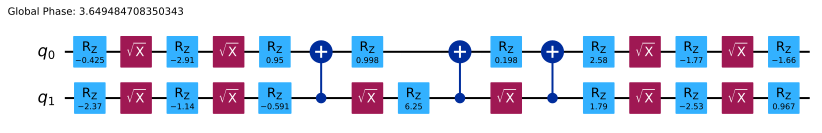

In [2]:
pass_manager = generate_preset_pass_manager(
    optimization_level=1, seed_transpiler=11, basis_gates=["sx", "rz", "cx"]
)
optimized_1 = pass_manager.run(qc)
optimized_1.draw("mpl")

<span id="init-layout"></span>
## Initial layout

Before transpilation, the qubits contained in your circuit are virtual qubits that don't necessarily correspond to physical qubits on the target backend. You can specify the initial mapping of virtual qubits to physical qubits using the `initial_layout` argument. Note that the final qubit layout may differ from the initial layout because the transpiler may permute qubits using swap gates or other means.

In the example below, we construct an initial layout for the [`FakeSherbrooke`](/api/qiskit-ibm-runtime/fake-provider-fake-sherbrooke#fakesherbrooke) mock backend by creating a [`Layout`](/api/qiskit/qiskit.transpiler.Layout) object. Our layout maps the first qubit of our circuit to qubit 5 of Sherbrooke, and it maps the second qubit of our circuit to qubit 6 of Sherbrooke. Note that physical qubits are always represented by integers.

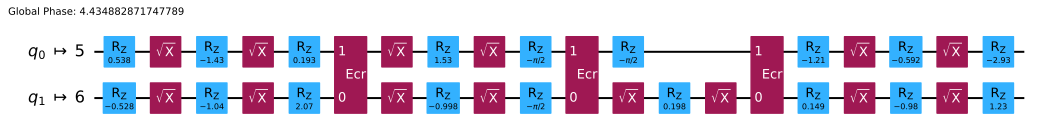

In [3]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.transpiler import Layout

backend = FakeSherbrooke()

a, b = qubits
initial_layout = Layout({a: 5, b: 6})

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, initial_layout=initial_layout
)
transpiled_circ = pass_manager.run(qc)

transpiled_circ.draw("mpl", idle_wires=False)

In addition to specifying a Layout object, you can also pass a list of integers, where the $i$-th element of the list contains the physical qubit that the $i$-th qubit should be mapped to. For example:

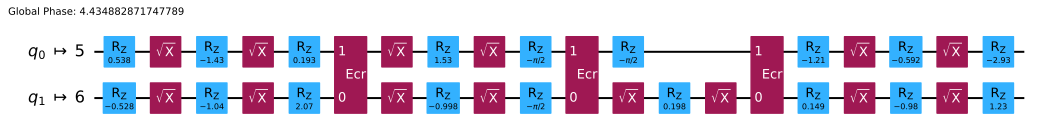

In [4]:
initial_layout = [5, 6]

pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, initial_layout=initial_layout
)
transpiled_circ = pass_manager.run(qc)

transpiled_circ.draw("mpl", idle_wires=False)

You can use the [`plot_error_map`](/api/qiskit/qiskit.visualization.plot_error_map) function to generate a diagram of the device graph with error information and with the physical qubits labeled. You can also view similar diagrams at https://quantum.ibm.com/services/resources.

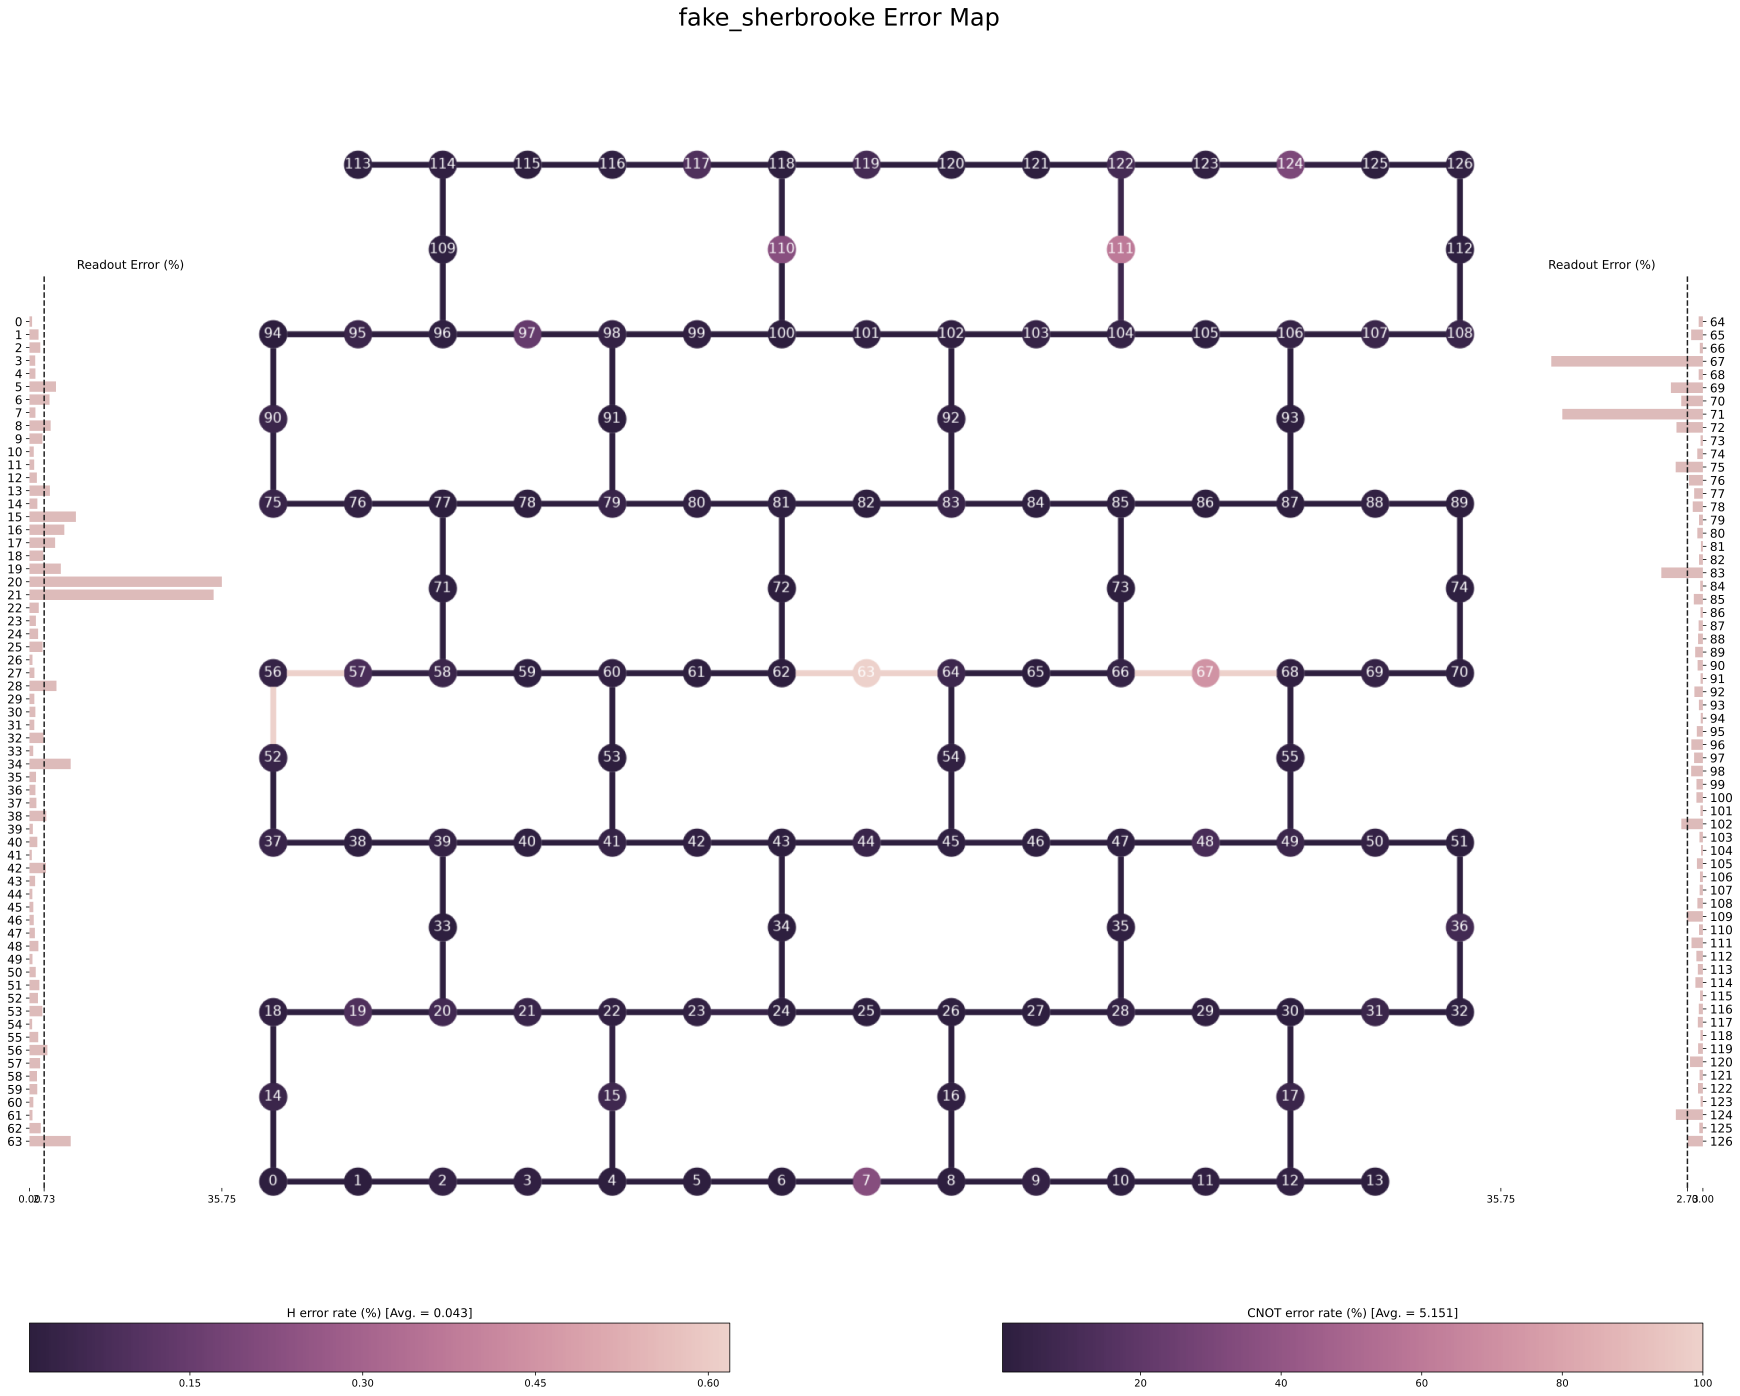

In [5]:
from qiskit.visualization import plot_error_map

plot_error_map(backend, figsize=(30, 24))

<span id="xx-method"></span>
## Transpiler stage and plugin options

These options are suffixed with `_method`. They influence how the transpiler works and are used to try and get better, different, or specific output from the transpiler.

* `init_method` (str) - The plugin to use for the initialization stage.

* `layout_method` (str) - The layout selection pass (`trivial`, `dense`, `sabre`). This can also be the external plugin name to use for the layout stage.

* `optimization_method` (str) - The plugin to use for the optimization stage.

* `routing_method` (str) - Name of routing pass (`basic`, `lookahead`, `stochastic`, `sabre`, `none`). This can also be the external plugin name to use for the routing stage.

* `scheduling_method` (str) - Name of scheduling pass. This can also be the external plugin name to use for the scheduling stage.
  * `as_soon_as_possible`: Schedule instructions greedily: as early as possible on a qubit resource (alias: `asap`).
  * `as_late_as_possible`: Schedule instructions late.  That is, keep qubits in the ground state when possible (alias: `alap`).

* `translation_method` (str) - Name of translation pass (`unroller`, `translator`, `synthesis`). This can also be the external plugin name to use for the translation stage.

* `unitary_synthesis_method` (str) - The name of the unitary synthesis method to use. By default `default` is used.

<Admonition>
  To see a list of all installed plugins for a given stage, run [`list_stage_plugins("stage_name")`](https://docs.quantum.ibm.com/api/qiskit/transpiler_plugins#plugin-api). For example, if you want to see a list of all installed plugins for the routing stage, run `list_stage_plugins(routing)`.
</Admonition>

## Next steps

<Admonition type="tip" title="Recommendation">
    - Review the [Default options and configuration settings](defaults-and-configuration-options) topic.
    - Learn how to [Set the optimization level.](set-optimization)
    - Try the [Submit transpiled circuits](https://learning.quantum.ibm.com/tutorial/submit-transpiled-circuits) tutorial.
    - Review the [Transpile API documentation.](/api/qiskit/transpiler)

</Admonition>